# NF Ton IoT v2 Dataset - Hyperparameter Tuning Notebook

##Importing the necessary libraries

In [19]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, brier_score_loss, roc_auc_score, average_precision_score

## Set a fixed random seed for reproducibility across all relevant libraries and operations.

In [17]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensuring that PyTorch's convolution operations are deterministic
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(42)

## Loading and Preprocessing the NF Ton IoT v2 Dataset:

In [5]:
# Downloading the Dataset
!gdown --id 1JNsyqlCwT8IVudqj3yZ1y6wgbG7me5Pq
!unzip /content/NF-ToN-IoT-v2.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1JNsyqlCwT8IVudqj3yZ1y6wgbG7me5Pq
From (redirected): https://drive.google.com/uc?id=1JNsyqlCwT8IVudqj3yZ1y6wgbG7me5Pq&confirm=t&uuid=c1e126c7-1235-485a-9557-b6302d5dc3de
To: /content/NF-ToN-IoT-v2.zip
100% 185M/185M [00:05<00:00, 34.9MB/s]
Archive:  /content/NF-ToN-IoT-v2.zip
  inflating: NF-ToN-IoT-v2/NetFlow_v2_Features.csv  
  inflating: NF-ToN-IoT-v2/NF-ToN-IoT-v2.csv  


In [6]:
# Loading the NF-ToN-IoT-v2 dataset from a CSV file into a DataFrame. This process takes approximately 46 seconds.
df_whole = pd.read_csv("/content/NF-ToN-IoT-v2/NF-ToN-IoT-v2.csv")

# Dropping specific columns from the DataFrame that are not required for the analysis.
# These include 'Attack', 'IPV4_SRC_ADDR', 'IPV4_DST_ADDR', and certain byte-related columns.
df = df_whole.drop(columns=["Attack","IPV4_SRC_ADDR", "IPV4_DST_ADDR","SRC_TO_DST_SECOND_BYTES","DST_TO_SRC_SECOND_BYTES"])

# Converting all columns in the DataFrame to float type for consistency and to facilitate numerical operations.
df = df.astype(float)

# Reducing the dataset size by randomly sampling 0.1% of the data to make the dataset more manageable and speed up computations.
# The random state is set to 42 for reproducibility.
df = df.sample(frac=0.001, random_state=42)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16940 entries, 14986849 to 16012277
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   L4_SRC_PORT                  16940 non-null  float64
 1   L4_DST_PORT                  16940 non-null  float64
 2   PROTOCOL                     16940 non-null  float64
 3   L7_PROTO                     16940 non-null  float64
 4   IN_BYTES                     16940 non-null  float64
 5   IN_PKTS                      16940 non-null  float64
 6   OUT_BYTES                    16940 non-null  float64
 7   OUT_PKTS                     16940 non-null  float64
 8   TCP_FLAGS                    16940 non-null  float64
 9   CLIENT_TCP_FLAGS             16940 non-null  float64
 10  SERVER_TCP_FLAGS             16940 non-null  float64
 11  FLOW_DURATION_MILLISECONDS   16940 non-null  float64
 12  DURATION_IN                  16940 non-null  float64
 13  DURATI

In [8]:
# Extract feature matrix (X) and target vector (y) from the dataframe
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

#Splitting the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
def normalize(data,  mean_i, min_i , max_i ):
    """
    Normalizes the data
    Parameters:
    - data: The data to be normalized
    - mean_i: The mean of the data
    - min_i: The minimum value of the data
    - max_i: The maximum value of the data
    """
    eps = 1e-15
    r = max_i - min_i + eps
    data = (data - mean_i) / r

    return data

mean_i = np.mean(X_train, axis=0)
min_i = np.min(X_train, axis=0)
max_i = np.max(X_train, axis=0)

X_train = normalize(X_train,  mean_i, min_i , max_i )
X_test = normalize(X_test,  mean_i, min_i , max_i )

In [10]:
# Data Conversion to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

## Defining a Transformer-based model

In [11]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout
            ),
            num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add a fake batch dimension for the transformer
        x = self.transformer_encoder(x)  # Pass through the encoder
        x = x.squeeze(1)
        x = self.fc(x)
        return x

## Defining the evaluation function

In [12]:
def evaluate_model(test_loader, model, device, dim_feedforward):
    model.to(device)
    model.eval()
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            predicted_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    predicted_probs = np.array(predicted_probs)
    accuracy = accuracy_score(true_labels, predicted_labels)

    brier_score = brier_score_loss(true_labels, predicted_probs[:, 1])
    pr_auc = average_precision_score(true_labels, predicted_probs[:, 1])
    roc_auc = roc_auc_score(true_labels, predicted_probs[:, 1])
    metrics = {
        'dim_feedforward': dim_feedforward,
        'accuracy': accuracy,
        'brier_score': brier_score,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

    return metrics


## Defining the training function

In [13]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model = model.to(device)
    for epoch in range(num_epochs):
      model.train()
      running_loss = 0.00

      for i, (data, labels) in enumerate(train_loader):
          data, labels = data.cuda(), labels.cuda()
          outputs = model(data)
          loss = criterion(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      # Calculate and log average metrics for the epoch
      average_loss = running_loss / len(train_loader)

      print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {average_loss:.4f}")


##Experimenting hyperparameters

###Default hyperparameters

https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html

In [20]:
# Set hyperparameters
hyperparams = {
    'batch_size': 1024,
    'num_epochs': 5,
    'learning_rate': 0.001,
    'd_model': 512,
    'nhead': 8,
    'num_layers': 6,
    'dim_feedforward': 2048,
    'dropout': 0.1,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

train_loader = DataLoader(train_dataset, hyperparams['batch_size'])
test_loader = DataLoader(test_dataset, hyperparams['batch_size'] )

# Initialize model
model = TransformerModel(
    input_dim = X_train.shape[1],
    num_classes = len(np.unique([y_train])),
    d_model=hyperparams['d_model'],
    nhead=hyperparams['nhead'],
    num_layers=hyperparams['num_layers'],
    dim_feedforward=hyperparams['dim_feedforward'],
    dropout=hyperparams['dropout']
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])

# Train and evaluate
train_model(model, train_loader, criterion, optimizer, hyperparams['num_epochs'], hyperparams["device"] )
metrics = evaluate_model(test_loader, model, hyperparams["device"], hyperparams["dim_feedforward"])
metrics = pd.DataFrame(metrics, index=[0])
all_metrics = pd.concat([all_metrics, metrics], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/5], Average Loss: 1.1588
Epoch [2/5], Average Loss: 0.6641
Epoch [3/5], Average Loss: 0.6541
Epoch [4/5], Average Loss: 0.6518
Epoch [5/5], Average Loss: 0.6520


In [52]:
all_metrics_feedforward = pd.DataFrame()

##Tuning dim_feedforward

In [63]:
dim_feedforward = int(1048*4)

# Initialize model
model = TransformerModel(
    input_dim = X_train.shape[1],
    num_classes = len(np.unique([y_train])),
    d_model=hyperparams['d_model'],
    nhead=hyperparams['nhead'],
    num_layers=hyperparams['num_layers'],
    dim_feedforward = dim_feedforward ,
    dropout=hyperparams['dropout']
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])

# Train and evaluate
train_model(model, train_loader, criterion, optimizer, hyperparams['num_epochs'], hyperparams["device"] )
metrics = evaluate_model(test_loader, model, hyperparams["device"], dim_feedforward)
metrics = pd.DataFrame(metrics, index=[0])
all_metrics_feedforward = pd.concat([all_metrics_feedforward, metrics], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/5], Average Loss: 1.3608
Epoch [2/5], Average Loss: 0.6613
Epoch [3/5], Average Loss: 0.6526
Epoch [4/5], Average Loss: 0.6519
Epoch [5/5], Average Loss: 0.6518


In [64]:
all_metrics_feedforward

,dim_feedforward,accuracy,brier_score,roc_auc,pr_auc
0,26,0.644038,0.229305,0.740116,0.799597
1,52,0.644038,0.230058,0.703067,0.816156
2,104,0.644038,0.229387,0.664384,0.786067
3,131,0.644038,0.229254,0.741625,0.825804
4,174,0.644038,0.229257,0.714707,0.815492
5,524,0.644038,0.230179,0.721953,0.821390
6,1048,0.644038,0.229391,0.692131,0.786837
7,2096,0.644038,0.229341,0.494847,0.641713
8,3144,0.644038,0.229556,0.500782,0.645920
9,4192,0.644038,0.229485,0.498857,0.643525


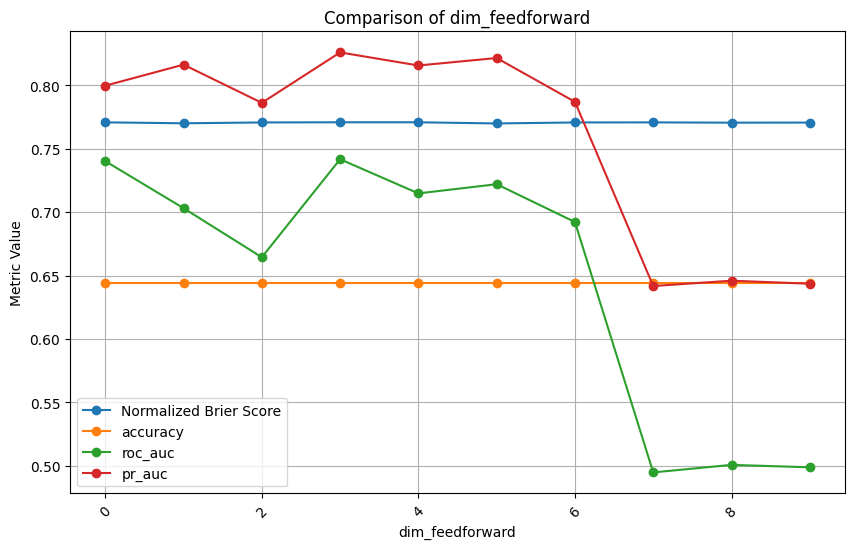

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

all_metrics_feedforward['Normalized Brier Score'] = 1 - all_metrics_feedforward['brier_score']

# Metrics to plot, now including 'Size on Disk (KB)' directly for simplicity
metrics_for_plot = ['Normalized Brier Score', "accuracy", "roc_auc", "pr_auc"  ]

# Plotting
plt.figure(figsize=(10, 6))
for metric in metrics_for_plot:
    plt.plot(all_metrics_feedforward.index, all_metrics_feedforward[metric], label=metric, marker='o')

# Adding labels and title
plt.xlabel('dim_feedforward')
plt.ylabel('Metric Value')
plt.title('Comparison of dim_feedforward')
plt.xticks(rotation=45)
plt.legend()

plt.grid(True)
plt.show()

In [72]:
all_metrics_dmodel = pd.DataFrame()

In [91]:
dmodel = 600
#nhead = 8

# Initialize model
model = TransformerModel(
    input_dim = X_train.shape[1],
    num_classes = len(np.unique([y_train])),
    d_model=dmodel,
    nhead=hyperparams['nhead'],
    num_layers=hyperparams['num_layers'],
    dim_feedforward=hyperparams['dim_feedforward'],
    dropout=hyperparams['dropout']
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])

# Train and evaluate
train_model(model, train_loader, criterion, optimizer, hyperparams['num_epochs'], hyperparams["device"] )
metrics = evaluate_model(test_loader, model, hyperparams["device"], dmodel)
metrics = pd.DataFrame(metrics, index=[0])
all_metrics_dmodel = pd.concat([all_metrics_dmodel, metrics], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/5], Average Loss: 1.3532
Epoch [2/5], Average Loss: 0.6684
Epoch [3/5], Average Loss: 0.6562
Epoch [4/5], Average Loss: 0.6535
Epoch [5/5], Average Loss: 0.6529


In [92]:
all_metrics_dmodel

,dim_feedforward,accuracy,brier_score,roc_auc,pr_auc,Normalized Brier Score
0,8,0.793684,0.156360,0.807742,0.842535,0.843640
1,16,0.713695,0.179055,0.762734,0.811354,0.820945
2,32,0.644038,0.191177,0.719291,0.842482,0.808823
3,48,0.808146,0.148104,0.855081,0.899569,0.851896
4,64,0.644038,0.229307,0.777526,0.850628,0.770693
5,80,0.644038,0.229345,0.764335,0.853353,0.770655
6,120,0.644038,0.229498,0.683452,0.821605,0.770502
7,160,0.644038,0.229294,0.772634,0.851946,0.770706
8,240,0.644038,0.229360,0.745408,0.833387,0.770640
9,320,0.644038,0.229243,0.692007,0.821111,NaN


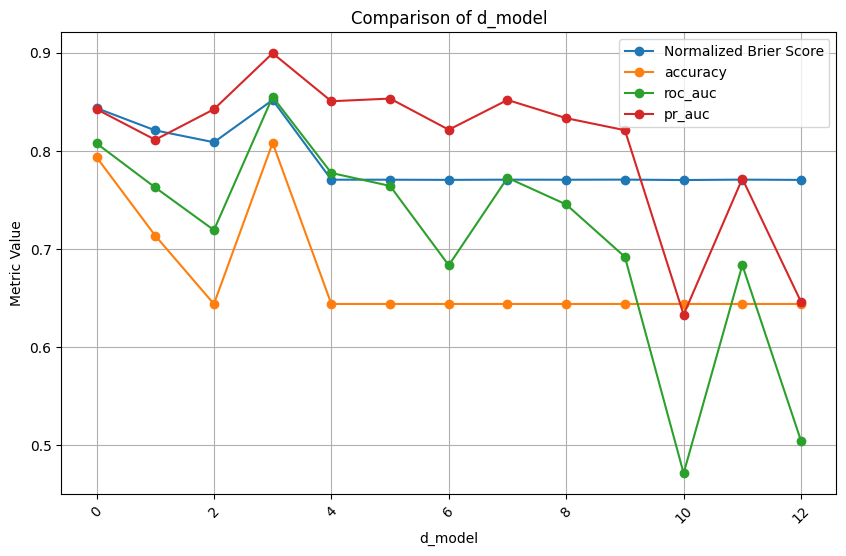

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

all_metrics_dmodel['Normalized Brier Score'] = 1 - all_metrics_dmodel['brier_score']

# Metrics to plot, now including 'Size on Disk (KB)' directly for simplicity
metrics_for_plot = ['Normalized Brier Score', "accuracy", "roc_auc", "pr_auc"  ]

# Plotting
plt.figure(figsize=(10, 6))
for metric in metrics_for_plot:
    plt.plot(all_metrics_dmodel.index, all_metrics_dmodel[metric], label=metric, marker='o')

# Adding labels and title
plt.xlabel('d_model')
plt.ylabel('Metric Value')
plt.title('Comparison of d_model')
plt.xticks(rotation=45)
plt.legend()

plt.grid(True)
plt.show()

In [94]:
all_metrics_dmodel = pd.DataFrame()